In [1]:
!pip install qiskit qiskit-aer torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00


In [2]:
# ライブラリの読み込み
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import time

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

In [3]:
# --- 量子サンプル生成 ---
def generate_quantum_samples(num_qubits, num_samples):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.h(q)
    qc.measure(range(num_qubits), range(num_qubits))

    backend = Aer.get_backend('aer_simulator')
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=num_samples)
    result = job.result()
    counts = result.get_counts()

    samples = []
    for bitstring, count in counts.items():
        arr = [2 * int(b) - 1 for b in reversed(bitstring)]
        samples.extend([arr] * count)

    samples = samples[:num_samples]
    return torch.tensor(samples, dtype=torch.float32)


# --- VAEモデル定義 ---
class VAE(nn.Module):
    def __init__(self, z_dim, device='cuda'):
        super().__init__()
        self.device = device
        self.z_dim = z_dim

        self.enc_mean = nn.Linear(200, z_dim)
        self.enc_var = nn.Linear(200, z_dim)

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 28 * 28),
            nn.Sigmoid()
        )

    def _encoder(self, x):
        h = self.encoder(x)
        mean = self.enc_mean(h)
        var = F.softplus(self.enc_var(h))
        return mean, var

    def _sample_z(self, mean, var):
        batch_size = mean.shape[0]
        quantum_eps = generate_quantum_samples(self.z_dim, batch_size).to(self.device)
        return mean + torch.sqrt(var) * quantum_eps

    def _decoder(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        y = self._decoder(z)
        return y, z

    def loss(self, x):
        mean, var = self._encoder(x)
        KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))
        z = self._sample_z(mean, var)
        y = self._decoder(z)
        reconstruction = torch.mean(
            torch.sum(
                x * torch.log(y + 1e-8) + (1 - x) * torch.log(1 - y + 1e-8),
                dim=1
            )
        )
        lower_bound = reconstruction - KL
        return lower_bound


In [4]:
# --- 学習用データ準備（MNIST） ---
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# --- 学習設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 10
model = VAE(latent_dim, device).to(device)
criterion = model.loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
train_loss_list = []

# --- 学習ループ ---
for epoch in range(epochs):
    batch_loss_list = []
    model.train()
    start_time = time.time()

    for x, _ in train_loader:
        x = x.view(-1, 28 * 28).to(device)
        loss = -1 * criterion(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss_list.append(loss.item())

    epoch_time = time.time() - start_time
    train_loss_list.append(np.mean(batch_loss_list))

    if epoch % 5 == 0:
        print(f'Epoch {epoch + 1:02d}, Loss: {train_loss_list[-1]:.4f}, Time: {epoch_time:.2f}s')


100%|██████████| 9.91M/9.91M [00:00<00:00, 41.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Epoch 01, Loss: 191.2111, Time: 78.99s
Epoch 06, Loss: 113.4483, Time: 78.09s
Epoch 11, Loss: 106.9987, Time: 78.02s
Epoch 16, Loss: 104.4679, Time: 78.61s


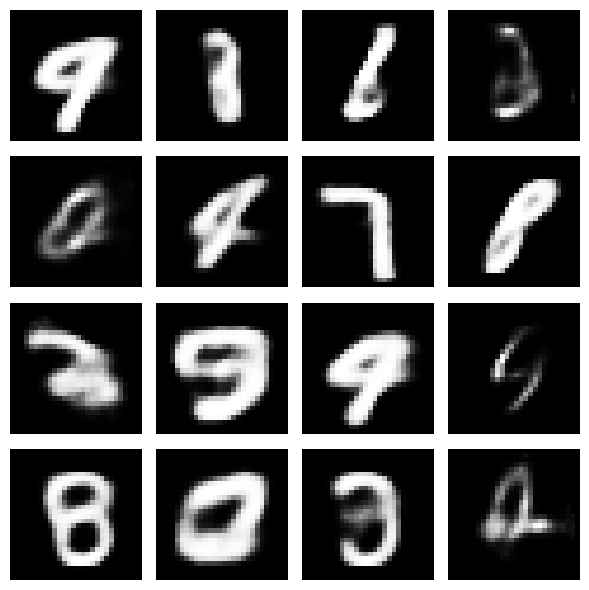

In [5]:
# --- 学習完了後の生成例（optional） ---
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = model._decoder(z).cpu().numpy()
    samples = samples.reshape(-1, 28, 28)

    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

103.29793159793944


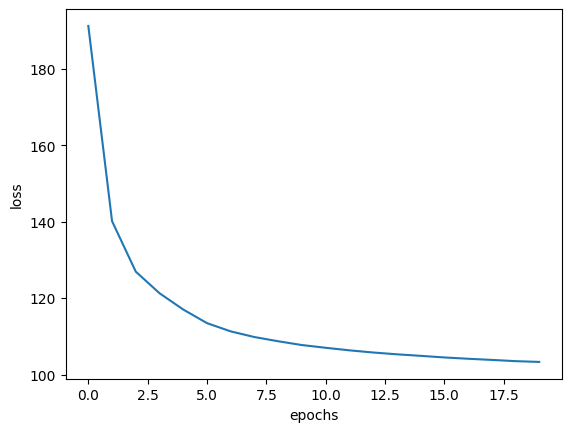

In [6]:
# 訓練損失の表示
print(train_loss_list[-1])
plt.plot(train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()